In [1]:
%matplotlib inline


# GroupLasso for linear regression with dummy variables

A sample script for group lasso with dummy variables


## Setup



In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from group_lasso import GroupLasso
from group_lasso.utils import extract_ohe_groups

np.random.seed(42)
GroupLasso.LOG_LOSSES = True

## Set dataset parameters



In [3]:
num_categories = 30
min_options = 2
max_options = 10
num_datapoints = 10000
noise_std = 1

## Generate data matrix



In [4]:
X_cat = np.empty((num_datapoints, num_categories))
for i in range(num_categories):
    X_cat[:, i] = np.random.randint(min_options, max_options, num_datapoints)

ohe = OneHotEncoder()
X = ohe.fit_transform(X_cat)
groups = extract_ohe_groups(ohe)
group_sizes = [np.sum(groups == g) for g in np.unique(groups)]
active_groups = [np.random.randint(0, 2) for _ in np.unique(groups)]

In [5]:
X.shape

(10000, 240)

## Generate coefficients



In [6]:
w = np.concatenate(
    [
        np.random.standard_normal(group_size) * is_active
        for group_size, is_active in zip(group_sizes, active_groups)
    ]
)
w = w.reshape(-1, 1)
true_coefficient_mask = w != 0
intercept = 2

## Generate regression targets



In [7]:
y_true = X @ w + intercept
y = y_true + np.random.randn(*y_true.shape) * noise_std

## View noisy data and compute maximum R^2



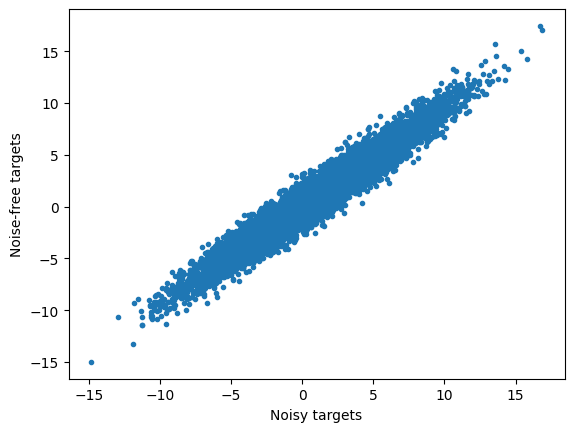

In [8]:
plt.figure()
plt.plot(y, y_true, ".")
plt.xlabel("Noisy targets")
plt.ylabel("Noise-free targets")
# Use noisy y as true because that is what we would have access
# to in a real-life setting.
R2_best = r2_score(y, y_true)

## Generate pipeline and train it



In [9]:
pipe = pipe = Pipeline(
    memory=None,
    steps=[
        (
            "variable_selection",
            GroupLasso(
                groups=groups,
                group_reg=0.1,
                l1_reg=0,
                scale_reg=None,
                supress_warning=True,
                n_iter=100000,
                frobenius_lipschitz=False,
            ),
        ),
        ("regressor", Ridge(alpha=1)),
    ],
)
pipe.fit(X, y)

Pipeline(steps=[('variable_selection',
                 GroupLasso(group_reg=0.1,
                            groups=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9., 10., 10., 10., 10., 10., 10., 10., 10., 1...
       21., 21., 21., 21., 21., 21., 21., 22., 22., 22., 22., 22., 22.,
       22., 22., 23., 23., 23., 23., 23., 23., 23., 23., 24., 24., 24.,
       24., 24., 24., 24., 24., 25., 25., 25., 25., 25., 25., 25., 25.,
       26., 26., 26., 26., 26., 26., 26., 26., 27., 27., 27., 27., 27.,
       27., 27., 27., 28., 28., 28., 28., 28., 28., 28., 28., 29., 29.,
       29., 29., 29., 29., 29., 29.]),
                            l1_reg=0, n_iter=100000, scale_reg=None,
                            supress_warning=True)),
                ('regressor', Ridge(alpha=1))])

## Extract results and compute performance metrics



In [10]:
# Extract from pipeline
yhat = pipe.predict(X)
sparsity_mask = pipe["variable_selection"].sparsity_mask_
coef = pipe["regressor"].coef_.T

# Construct full coefficient vector
w_hat = np.zeros_like(w)
w_hat[sparsity_mask] = coef

R2 = r2_score(y, yhat)

# Print performance metrics
print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"R^2: {R2}, best possible R^2 = {R2_best}")

Number variables: 240
Number of chosen variables: 144
R^2: 0.9278329839042153, best possible R^2 = 0.9394648554757948


## Visualise regression coefficients



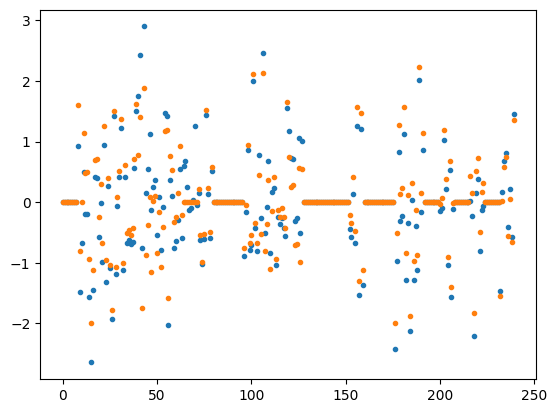

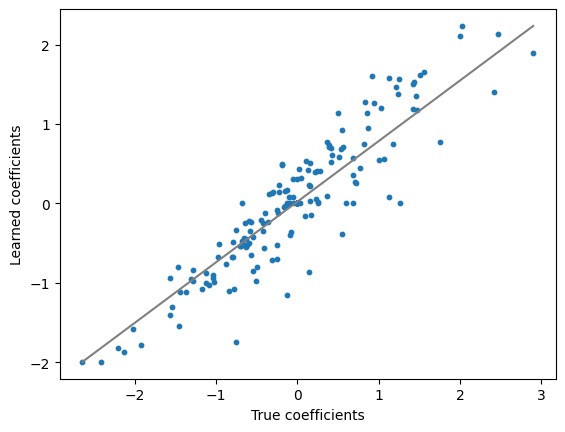

In [11]:
for i in range(w.shape[1]):
    plt.figure()
    plt.plot(w[:, i], ".", label="True weights")
    plt.plot(w_hat[:, i], ".", label="Estimated weights")

plt.figure()
plt.plot([w.min(), w.max()], [coef.min(), coef.max()], "gray")
plt.scatter(w, w_hat, s=10)
plt.ylabel("Learned coefficients")
plt.xlabel("True coefficients")
plt.show()